In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Lecture 24 #

## Reviewing Setup from Last Lecture

Recall, we actually had access to the population data.  This is not normally the case.  The methods we are about to study only make sense when you don't have access to the population. 

In [2]:
sf = Table.read_table('san_francisco_2019.csv')
min_salary = 15 * 20 * 50
sf = sf.where('Salary', are.above(min_salary))

In [3]:
sf.num_rows

37103

/Users/jegonzal/miniconda3/envs/data8/lib/python3.9/site-packages/datascience/tables.py:5865: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis.set_xticklabels(ticks, rotation='vertical')


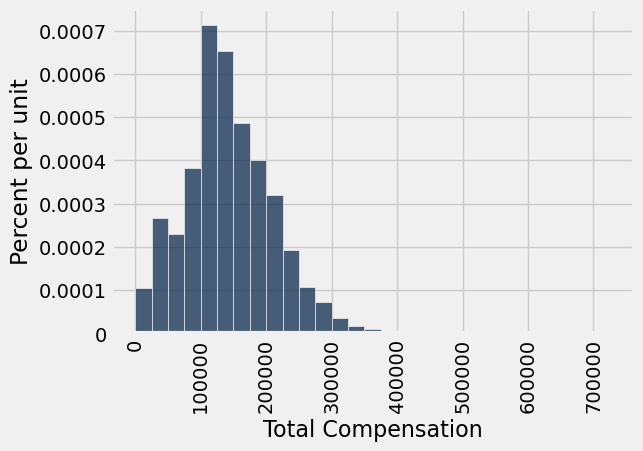

In [4]:
sf_bins = np.arange(0, 726000, 25000)
sf.hist('Total Compensation', bins=sf_bins)

In [5]:
# Parameter: Median total compensation in the population
def median_comp(t):
    return percentile(50, t.column('Total Compensation'))

median_comp(sf)

135747.0

## Bootstrap Estimates of the Parameter (Pretend it is Unknown) 

In [6]:
def confidence_interval_95(sample_size):
    # Collect one random sample from the population
    our_sample = sf.sample(sample_size, with_replacement=False)
    median_comp(our_sample)

    # Generate the medians of 1000 bootstrap samples
    num_repetitions = 1000
    bstrap_medians = make_array()
    for i in np.arange(num_repetitions):
        # Resample the same number of rows, with replacement
        bstrap_medians = np.append(bstrap_medians, 
                                   median_comp(our_sample.sample()))

    # Find the middle 95% of medians; that's a confidence interval
    left = percentile(2.5, bstrap_medians)
    right = percentile(97.5, bstrap_medians)
    return make_array(left, right)

confidence_interval_95(100)

array([ 129256.,  154538.])

In [7]:
intervals = Table(['k', 'lower', 'upper', 'sample_size'])

for n in [2, 4, 8, 16]:
    for k in np.arange(intervals.num_rows, intervals.num_rows + 20):
        interval = confidence_interval_95(n)
        intervals = intervals.with_row([
            k, interval.item(0), interval.item(1), n
        ])
    
intervals.show(4)

k,lower,upper,sample_size
0,124946,219364,2
1,165412,217880,2
2,25563,159376,2
3,207749,215050,2


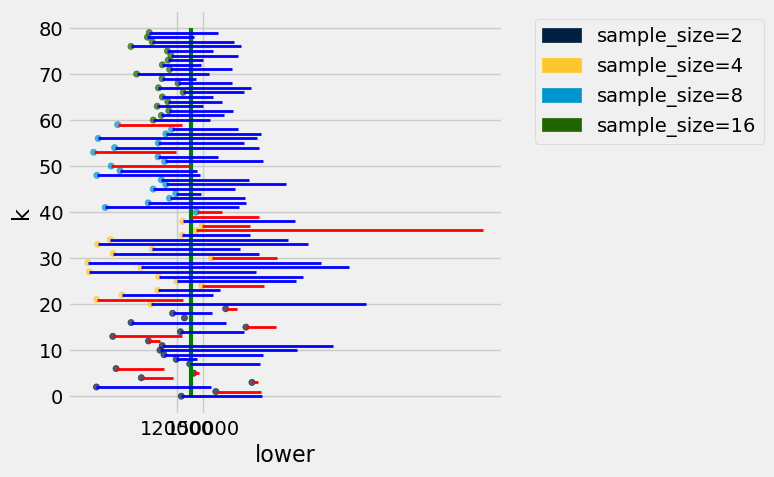

In [8]:
intervals.scatter('lower', 'k', group='sample_size')
truth = median_comp(sf)
plots.plot((truth, truth), (0, intervals.num_rows), color='green', lw=3)
plots.xticks([120000, 150000])
for row in intervals.rows:
    if row.item('lower') > truth or row.item('upper') < truth:
        color = 'red'
    else:
        color = 'blue'
    plots.plot((row.item('lower'), row.item('upper')),
               (row.item('k'), row.item('k')),
               color, lw=2)

## Confidence Interval for Unknown Population Mean

In [9]:
# Random sample of mother-newborn pairs
births = Table.read_table('baby.csv')

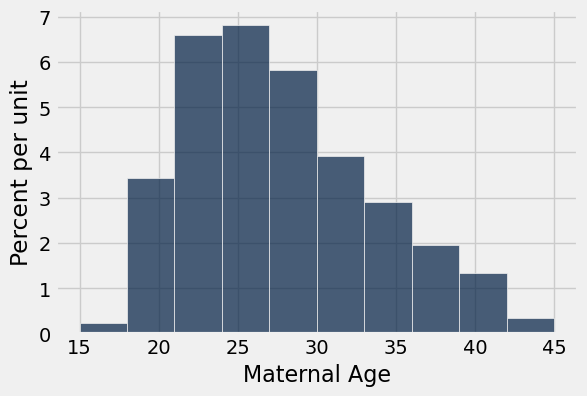

In [10]:
births.hist('Maternal Age')

In [11]:
# Average age of mothers in the sample
np.average(births.column('Maternal Age'))

27.228279386712096

### Question
What is the average age of the mothers in the population?

In [12]:
def one_bootstrap_mean():
    resample = births.sample()
    return np.average(resample.column('Maternal Age'))

In [13]:
# Generate means from 3000 bootstrap samples
num_repetitions = 3000
bstrap_means = make_array()
for i in np.arange(num_repetitions):
    bstrap_means = np.append(bstrap_means, one_bootstrap_mean())

### Bootstrap Percentile Method for Confidence Interval

The interval of estimates is the "middle 95%" of the bootstrap estimates.

This is called a *95% confidence interval* for the mean age in the population.

In [14]:
# Get the endpoints of the 95% confidence interval
left = percentile(2.5, bstrap_means)
right = percentile(97.5, bstrap_means)

make_array(left, right)

array([ 26.89522998,  27.56473595])

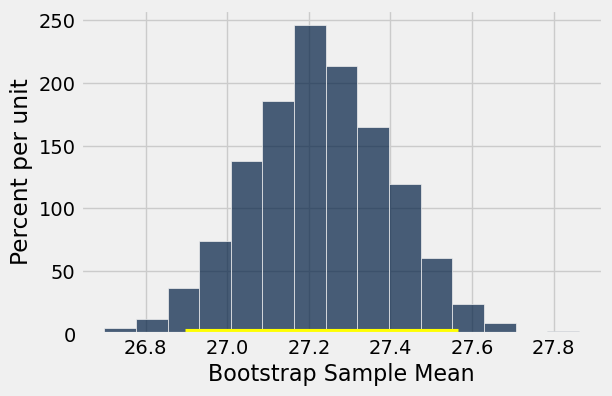

In [15]:
resampled_means = Table().with_columns(
    'Bootstrap Sample Mean', bstrap_means
)
resampled_means.hist(bins=15)
plots.plot([left, right], [0, 0], color='yellow', lw=8);

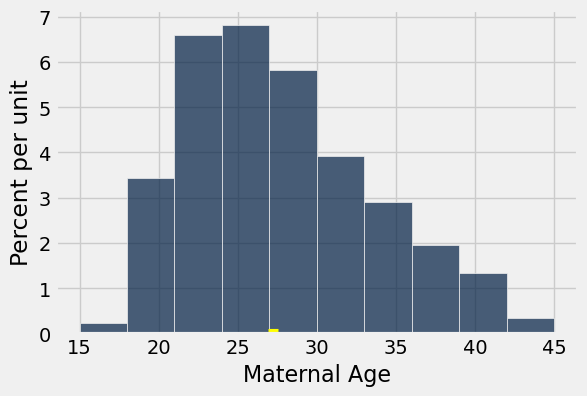

In [16]:
births.hist('Maternal Age')
plots.plot([left, right], [0, 0], color='yellow', lw=8);

## Using the Confidence Interval for Testing Hypotheses

**Null:** The average age of mothers in the population is 25 years; the random sample average is different due to chance.

**Alternative:** The average age of the mothers in the population is not 25 years.

Suppose you use the 5% cutoff for the p-value.

Based on the confidence interval, which hypothesis would you pick?